In [13]:
import os
import sys
import pathlib
import pickle as pkl
import json
import itertools

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

from tqdm import tqdm

import fir.utils.time
import fir.utils.dict

from time import time
from datetime import datetime

import pprint
import math

In [14]:
def load_json_dict(
        json_filename
        ):

    with open(json_filename, 'r') as json_file:
        json_dict = json.load(json_file)

    return json_dict

---

In [15]:
exp_dirname = os.path.join(pathlib.Path.home(), "data", "fashion_retrieval", "ret_train_DDP_2")

backbones = ["swint_v2_t"]
num_exps_list = [14]

df_records = []

for backbone, num_exps in zip(backbones, num_exps_list):
    for exp_idx in range(num_exps):

        eval_filename = os.path.join(exp_dirname, backbone, "run_{:03d}".format(exp_idx), "eval_ctsrbm_metrics__data.json")
        eval_data = load_json_dict(eval_filename)

        exp_filename = os.path.join(exp_dirname, backbone, "run_{:03d}".format(exp_idx), "train_ret_DDP_stage_1__data.json")
        exp_data = load_json_dict(exp_filename)

        df_record = {}

        # exp_data

        df_record["backbone"] = exp_data["settings"]["backbone"]["class"]
        df_record["experiment_name"] = "test_{:03d}".format(exp_idx)

        num_gpus = len(exp_data["settings"]["gpu_usage"])
        df_record["num_gpus"] = num_gpus

        stage_1_batch_size = exp_data["settings"]["stage_1"]["data_loading"]["batch_size"]
        df_record["stage_1_batch_size"] = stage_1_batch_size

        stage_1_grad_acc_iters = fir.utils.dict.chain_get(exp_data, "settings", "stage_1", "data_loading", "grad_acc_iters", default=1)
        df_record["stage_1_grad_acc_iters"] = stage_1_grad_acc_iters

        df_record["stage_1_actual_batch_size"] = stage_1_batch_size * stage_1_grad_acc_iters * num_gpus

        df_record["stage_1_lr"] = exp_data["settings"]["stage_1"]["optimizer"]["lr"]

        df_record["stage_1_train_loss"] = sum(exp_data["results"]["stage_1"]["train_mean_loss_list"][-1])
        df_record["stage_1_val_loss"] = sum(exp_data["results"]["stage_1"]["val_mean_loss_list"][-1])

        # eval_data

        splits = ["test", "train", "val"]
        metrics = ["p", "r", "f1"]

        for split, metric in itertools.product(splits, metrics):

            value_key = "avg_{:s}_at_k_dict".format(metric)
            value_dict = eval_data["results"][split][value_key]

            for key, item in value_dict.items():

                column_name = "avg_{:s}_{:s}_at_{:s}".format(split, metric, key)
                df_record[column_name] = item

        df_records.append(df_record)
        

In [16]:
df = pd.DataFrame.from_records(df_records)

In [17]:
df

,backbone,experiment_name,num_gpus,stage_1_batch_size,stage_1_grad_acc_iters,stage_1_actual_batch_size,stage_1_lr,stage_1_train_loss,stage_1_val_loss,avg_test_p_at_same,...,avg_val_r_at_1,avg_val_r_at_10,avg_val_r_at_20,avg_val_r_at_50,avg_val_f1_at_same,avg_val_f1_at_all,avg_val_f1_at_1,avg_val_f1_at_10,avg_val_f1_at_20,avg_val_f1_at_50
0,SwinTransformerV2TinyBackbone,test_000,4,8,1,32,0.10000,0.114993,1.652204,0.029637,...,0.025042,0.077878,0.108288,0.171748,0.028804,0.00029,0.028580,0.019113,0.014374,0.009637
1,SwinTransformerV2TinyBackbone,test_001,4,8,1,32,0.03000,0.029698,0.453175,0.030482,...,0.026126,0.080748,0.111335,0.179092,0.030195,0.00029,0.029938,0.019859,0.014828,0.010096
2,SwinTransformerV2TinyBackbone,test_002,4,8,1,32,0.01000,0.010918,0.173232,0.032077,...,0.027762,0.080709,0.113981,0.178688,0.031638,0.00029,0.031771,0.019743,0.015047,0.010019
3,SwinTransformerV2TinyBackbone,test_003,4,8,1,32,0.00300,0.003911,0.056876,0.034816,...,0.029656,0.087988,0.120632,0.186475,0.034183,0.00029,0.034014,0.021596,0.016043,0.010522
4,SwinTransformerV2TinyBackbone,test_004,4,8,1,32,0.00100,0.002053,0.031078,0.037589,...,0.032954,0.093670,0.129044,0.196577,0.037885,0.00029,0.037607,0.023004,0.017028,0.011051
5,SwinTransformerV2TinyBackbone,test_005,4,16,1,64,0.10000,0.367232,1.824387,0.027828,...,0.023539,0.075095,0.106185,0.167912,0.027100,0.00029,0.027052,0.018356,0.014000,0.009419
6,SwinTransformerV2TinyBackbone,test_006,4,8,1,32,0.00030,0.007461,0.024562,0.039793,...,0.034304,0.094972,0.129883,0.196987,0.039288,0.00029,0.039231,0.023427,0.017208,0.011109
7,SwinTransformerV2TinyBackbone,test_007,4,8,1,32,0.00010,0.009525,0.026312,0.041062,...,0.034204,0.093730,0.126912,0.193513,0.039313,0.00029,0.039022,0.023152,0.016853,0.010912
8,SwinTransformerV2TinyBackbone,test_008,3,11,1,33,0.00003,0.012172,0.027480,0.039894,...,0.034667,0.091324,0.124612,0.188616,0.039919,0.00029,0.039405,0.022578,0.016581,0.010639
9,SwinTransformerV2TinyBackbone,test_009,3,11,1,33,0.00001,0.029425,0.035200,0.037708,...,0.032486,0.085343,0.114318,0.170000,0.037201,0.00029,0.037074,0.021126,0.015257,0.009606


In [29]:
df_2 = df.copy()

metric_name = "avg_val_r_at_10"

df_2 = df_2.sort_values(metric_name, ascending=False)
df_2 = df_2[[
    "backbone",
    "stage_1_actual_batch_size",
    "stage_1_grad_acc_iters",
    "stage_1_lr",
    "num_gpus",
    "stage_1_train_loss",
    metric_name
]]

df_2

,backbone,stage_1_actual_batch_size,stage_1_grad_acc_iters,stage_1_lr,num_gpus,stage_1_train_loss,avg_val_r_at_10
13,SwinTransformerV2TinyBackbone,255,1,0.00030,3,0.002900,0.097952
10,SwinTransformerV2TinyBackbone,15,1,0.00030,3,0.002961,0.097194
11,SwinTransformerV2TinyBackbone,63,1,0.00030,3,0.002990,0.096592
12,SwinTransformerV2TinyBackbone,129,1,0.00030,3,0.002725,0.096525
6,SwinTransformerV2TinyBackbone,32,1,0.00030,4,0.007461,0.094972
7,SwinTransformerV2TinyBackbone,32,1,0.00010,4,0.009525,0.093730
4,SwinTransformerV2TinyBackbone,32,1,0.00100,4,0.002053,0.093670
8,SwinTransformerV2TinyBackbone,33,1,0.00003,3,0.012172,0.091324
3,SwinTransformerV2TinyBackbone,32,1,0.00300,4,0.003911,0.087988
9,SwinTransformerV2TinyBackbone,33,1,0.00001,3,0.029425,0.085343


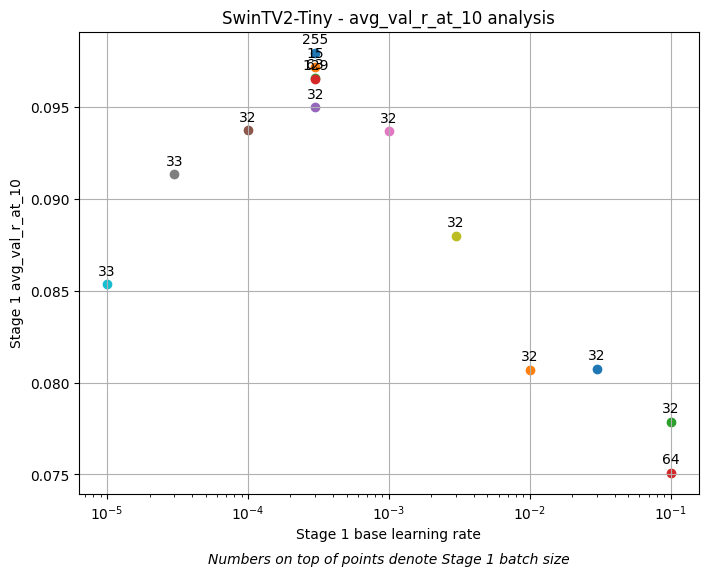

In [32]:
plt.figure(figsize=(8, 6))

for df_idx, df_row in df_2.iterrows():

    backbone = df_row["backbone"]
    grad_acc_iters_1 = df_row["stage_1_grad_acc_iters"]
    base_lr_1 = df_row["stage_1_lr"]
    num_gpus = df_row["num_gpus"]
    actual_batch_size_1 = df_row["stage_1_actual_batch_size"]

    val_loss = df_row["stage_1_train_loss"]
    metric = df_row[metric_name]

    plt.scatter(base_lr_1, metric)
    plt.text(base_lr_1, metric + 0.0005, actual_batch_size_1, ha="center")

plt.xscale("log")
plt.grid(True)

plt.title("SwinTV2-Tiny - {:s} analysis".format(metric_name))
plt.ylabel("Stage 1 {:s}".format(metric_name))
plt.xlabel("Stage 1 base learning rate")

l_xlim_0 = math.log10(plt.xlim()[0])
l_xlim_1 = math.log10(plt.xlim()[1])
l_xlim_alpha = 0.5

ylim_0 = plt.ylim()[0]
ylim_1 = plt.ylim()[1]
ylim_alpha = -0.15

text_x = 10 ** ((l_xlim_alpha * l_xlim_1) + ((1 - l_xlim_alpha) * l_xlim_0))
text_y = (ylim_alpha * ylim_1) + ((1 - ylim_alpha) * ylim_0)

plt.text(text_x, text_y, "Numbers on top of points denote Stage 1 batch size", ha="center", fontsize=10, fontstyle="italic")

plt.show()

---

# Extra

In [71]:
ord_df = df.sort_values("avg_test_f1_at_same", ascending=True)
ord_df = ord_df.reset_index(drop=True)

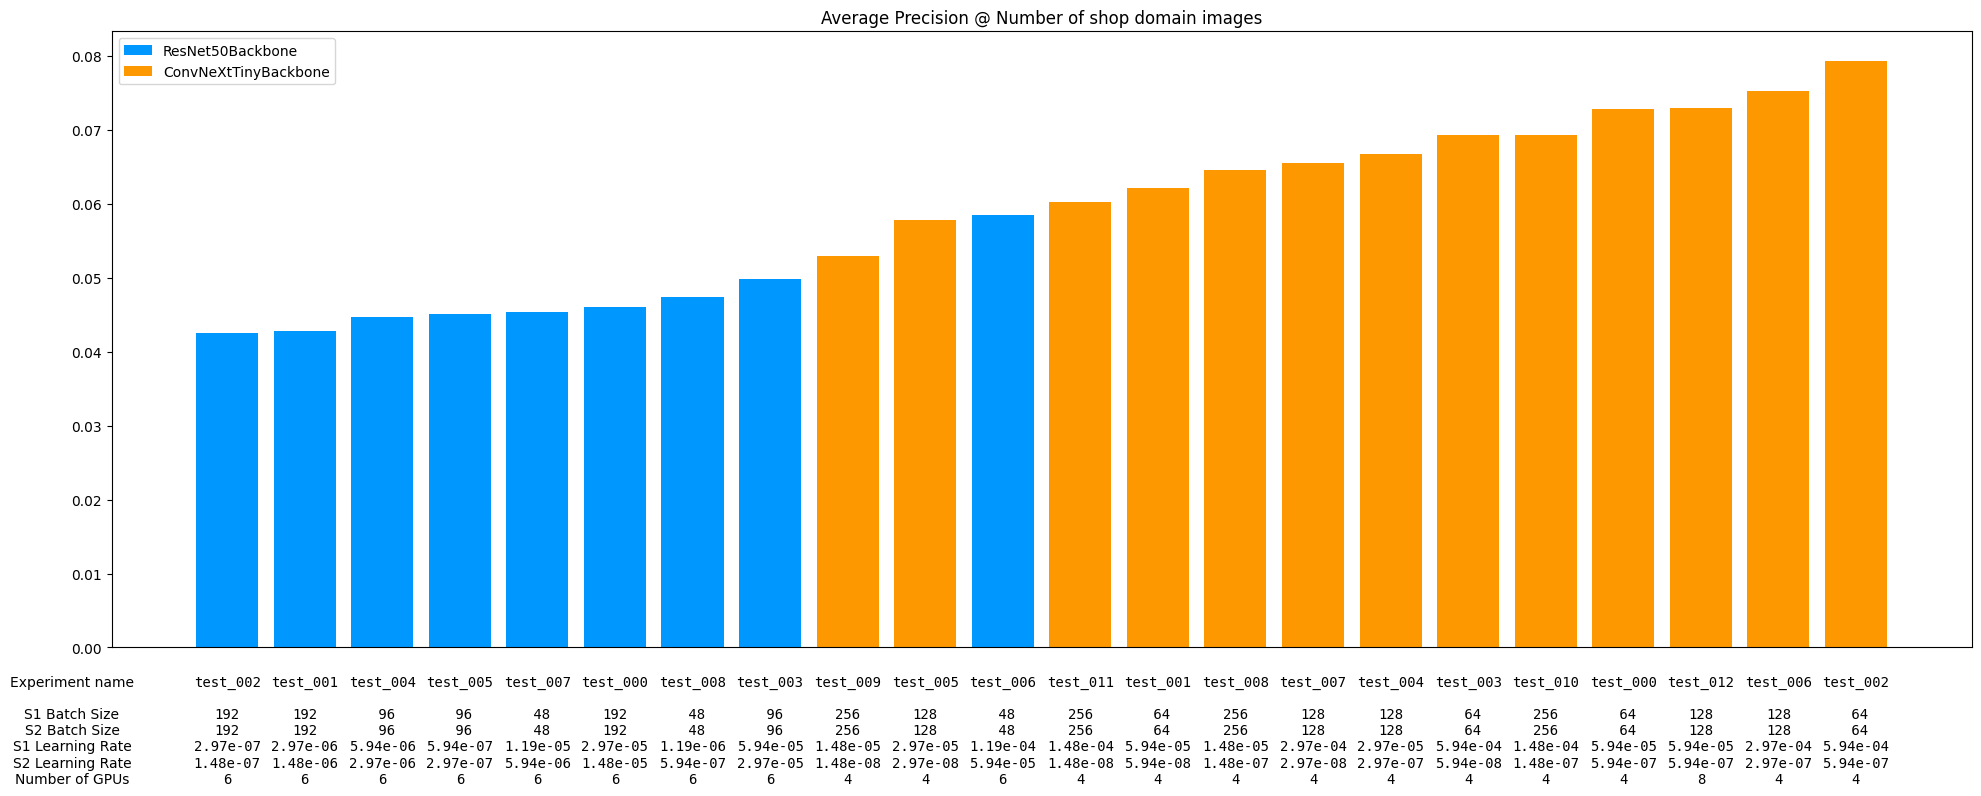

In [72]:
plt.figure(figsize=(24, 8))

###

bar_width = 0.8

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]
    
    if backbone == "ResNet50Backbone": backbone_color = np.asarray([0/256, 153/256, 255/256])
    if backbone == "EfficientNetB3Backbone": backbone_color = np.asarray([51/256, 153/256, 51/256])
    if backbone == "ConvNeXtTinyBackbone": backbone_color = np.asarray([255/256, 153/256, 0/256])

    plt.bar(np.asarray(ord_df_filt.index), ord_df_filt["avg_test_p_at_same"], color=backbone_color, alpha=1, label=backbone)

plt.legend()

###

plt.xticks([])
plt.title("Average Precision @ Number of shop domain images")

###

text_height = - plt.ylim()[1] * 0.22

text = "{:s}\n\n{:s}\n{:s}\n{:s}\n{:s}\n{:s}".format(
    "Experiment name",
    "S1 Batch Size",
    "S2 Batch Size",
    "S1 Learning Rate",
    "S2 Learning Rate",
    "Number of GPUs"
)
plt.text(-2, text_height, text, ha="center")

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]

    for idx in ord_df_filt.index:
        text = "{:s}\n\n{:3d}\n{:3d}\n{:3.2e}\n{:3.2e}\n{:1d}".format(
            ord_df_filt.at[idx, "experiment_name"],
            ord_df_filt.at[idx, "stage_1_actual_batch_size"],
            ord_df_filt.at[idx, "stage_2_actual_batch_size"],
            ord_df_filt.at[idx, "stage_1_base_lr"],
            ord_df_filt.at[idx, "stage_2_base_lr"],
            ord_df_filt.at[idx, "num_gpus"]
        )
        plt.text(idx, text_height, text, ha="center", family="monospace")
        
###

plt.show()

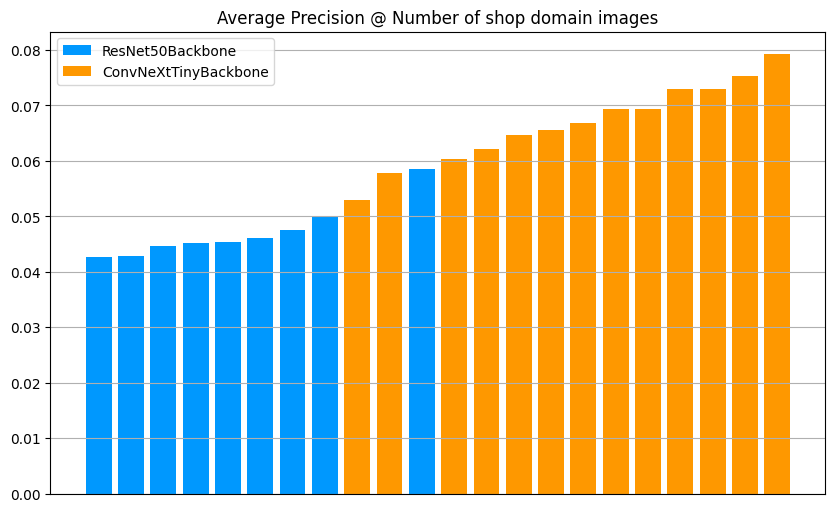

In [73]:
plt.figure(figsize=(10, 6))

###

bar_width = 0.8

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]
    
    if backbone == "ResNet50Backbone": backbone_color = np.asarray([0/256, 153/256, 255/256])
    if backbone == "EfficientNetB3Backbone": backbone_color = np.asarray([51/256, 153/256, 51/256])
    if backbone == "ConvNeXtTinyBackbone": backbone_color = np.asarray([255/256, 153/256, 0/256])

    plt.bar(np.asarray(ord_df_filt.index), ord_df_filt["avg_test_p_at_same"], color=backbone_color, alpha=1, label=backbone)

plt.legend()

###

plt.grid()
plt.xticks([])
plt.title("Average Precision @ Number of shop domain images")

###

"""
text_height = - plt.ylim()[1] * 0.22

text = "{:s}\n\n{:s}\n{:s}\n{:s}\n{:s}\n{:s}".format(
    "Experiment name",
    "S1 Batch Size",
    "S2 Batch Size",
    "S1 Learning Rate",
    "S2 Learning Rate",
    "Number of GPUs"
)
plt.text(-2, text_height, text, ha="center")

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]

    for idx in ord_df_filt.index:
        text = "{:s}\n\n{:3d}\n{:3d}\n{:3.2e}\n{:3.2e}\n{:1d}".format(
            ord_df_filt.at[idx, "experiment_name"],
            ord_df_filt.at[idx, "stage_1_actual_batch_size"],
            ord_df_filt.at[idx, "stage_2_actual_batch_size"],
            ord_df_filt.at[idx, "stage_1_base_lr"],
            ord_df_filt.at[idx, "stage_2_base_lr"],
            ord_df_filt.at[idx, "num_gpus"]
        )
        plt.text(idx, text_height, text, ha="center", family="monospace")
"""

###

plt.show()

In [74]:
debug_df = ord_df.copy()
debug_df = debug_df[debug_df["backbone"] == "ConvNeXtTinyBackbone"]

debug_df = debug_df[[
    "backbone",
    "experiment_name",
    "num_gpus",
    "stage_1_batch_size",
    "stage_2_batch_size",
    "stage_1_grad_acc_iters",
    "stage_2_grad_acc_iters",
    "stage_1_actual_batch_size",
    "stage_2_actual_batch_size",
    "stage_1_lr",
    "stage_2_lr",
    "stage_1_base_lr",
    "stage_2_base_lr",
    "avg_test_p_at_same"
]]

debug_df = debug_df.rename(columns={
    "experiment_name": "name",
    "num_gpus": "#gpus",
    "stage_1_batch_size": "s1_bs",
    "stage_2_batch_size": "s2_bs",
    "stage_1_grad_acc_iters": "s1_acc",
    "stage_2_grad_acc_iters": "s2_acc",
    "stage_1_actual_batch_size": "s1_abs",
    "stage_2_actual_batch_size": "s2_abs",
    "stage_1_lr": "s1_lr",
    "stage_2_lr": "s2_lr",
    "stage_1_base_lr": "s1_blr",
    "stage_2_base_lr": "s2_blr",
    "avg_test_p_at_same": "prec"
})

In [75]:
debug_df.sort_values("prec")

,backbone,name,#gpus,s1_bs,s2_bs,s1_acc,s2_acc,s1_abs,s2_abs,s1_lr,s2_lr,s1_blr,s2_blr,prec
8,ConvNeXtTinyBackbone,test_009,4,64,32,1,2,256,256,0.001,0.000001,0.000015,1.484375e-08,0.052881
9,ConvNeXtTinyBackbone,test_005,4,32,32,1,1,128,128,0.001,0.000001,0.000030,2.968750e-08,0.057770
11,ConvNeXtTinyBackbone,test_011,4,64,32,1,2,256,256,0.010,0.000001,0.000148,1.484375e-08,0.060247
12,ConvNeXtTinyBackbone,test_001,4,16,16,1,1,64,64,0.001,0.000001,0.000059,5.937500e-08,0.062196
13,ConvNeXtTinyBackbone,test_008,4,64,32,1,2,256,256,0.001,0.000010,0.000015,1.484375e-07,0.064604
14,ConvNeXtTinyBackbone,test_007,4,32,32,1,1,128,128,0.010,0.000001,0.000297,2.968750e-08,0.065571
15,ConvNeXtTinyBackbone,test_004,4,32,32,1,1,128,128,0.001,0.000010,0.000030,2.968750e-07,0.066764
16,ConvNeXtTinyBackbone,test_003,4,16,16,1,1,64,64,0.010,0.000001,0.000594,5.937500e-08,0.069330
17,ConvNeXtTinyBackbone,test_010,4,64,32,1,2,256,256,0.010,0.000010,0.000148,1.484375e-07,0.069374
18,ConvNeXtTinyBackbone,test_000,4,16,16,1,1,64,64,0.001,0.000010,0.000059,5.937500e-07,0.072864


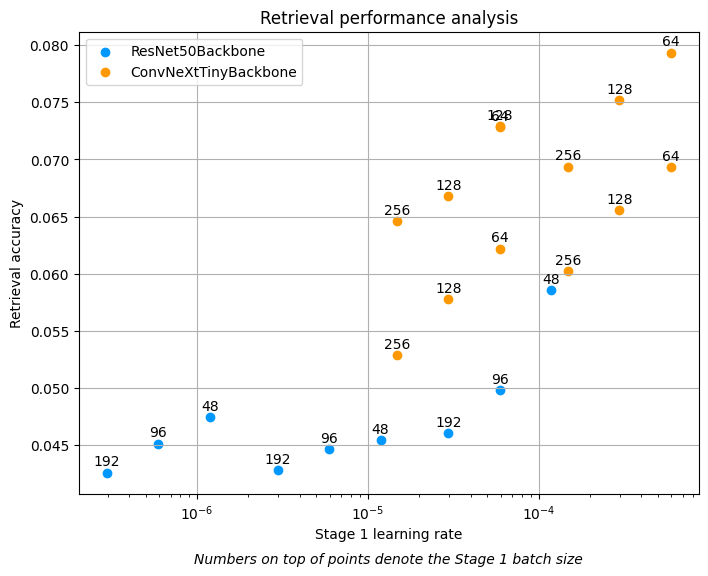

In [76]:
plt.figure(figsize=(8, 6))

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]
    
    if backbone == "ResNet50Backbone": backbone_color = np.asarray([0/256, 153/256, 255/256])
    if backbone == "EfficientNetB3Backbone": backbone_color = np.asarray([51/256, 153/256, 51/256])
    if backbone == "ConvNeXtTinyBackbone": backbone_color = np.asarray([255/256, 153/256, 0/256])

    plt.scatter(ord_df_filt["stage_1_base_lr"], ord_df_filt["avg_test_p_at_same"], color=backbone_color, alpha=1, label=backbone)
    
    for idx, row in ord_df_filt.iterrows():
        
        plt.text(row["stage_1_base_lr"], row["avg_test_p_at_same"] + 0.0006, row["stage_1_actual_batch_size"], ha="center")

#

plt.legend()

plt.xscale("log")
plt.grid(True)

plt.title("Retrieval performance analysis")
plt.xlabel("Stage 1 learning rate")
plt.ylabel("Retrieval accuracy")

l_xlim_0 = math.log10(plt.xlim()[0])
l_xlim_1 = math.log10(plt.xlim()[1])
l_xlim_alpha = 0.5

ylim_0 = plt.ylim()[0]
ylim_1 = plt.ylim()[1]
ylim_alpha = -0.15

text_x = 10 ** ((l_xlim_alpha * l_xlim_1) + ((1 - l_xlim_alpha) * l_xlim_0))
text_y = (ylim_alpha * ylim_1) + ((1 - ylim_alpha) * ylim_0)

plt.text(text_x, text_y, "Numbers on top of points denote the Stage 1 batch size", ha="center", fontsize=10, fontstyle="italic")

plt.show()

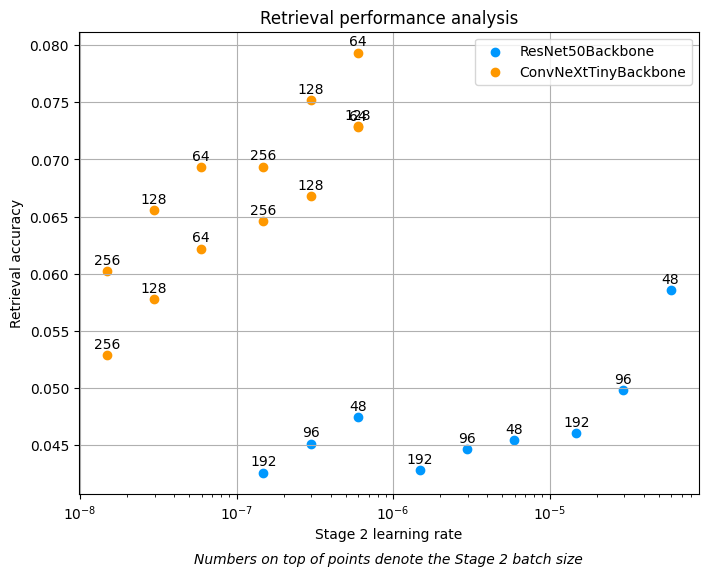

In [77]:
plt.figure(figsize=(8, 6))

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]
    
    if backbone == "ResNet50Backbone": backbone_color = np.asarray([0/256, 153/256, 255/256])
    if backbone == "EfficientNetB3Backbone": backbone_color = np.asarray([51/256, 153/256, 51/256])
    if backbone == "ConvNeXtTinyBackbone": backbone_color = np.asarray([255/256, 153/256, 0/256])

    plt.scatter(ord_df_filt["stage_2_base_lr"], ord_df_filt["avg_test_p_at_same"], color=backbone_color, alpha=1, label=backbone)
    
    for idx, row in ord_df_filt.iterrows():
        
        plt.text(row["stage_2_base_lr"], row["avg_test_p_at_same"] + 0.0006, row["stage_2_actual_batch_size"], ha="center")

#

plt.legend()

plt.xscale("log")
plt.grid(True)

plt.title("Retrieval performance analysis")
plt.xlabel("Stage 2 learning rate")
plt.ylabel("Retrieval accuracy")

l_xlim_0 = math.log10(plt.xlim()[0])
l_xlim_1 = math.log10(plt.xlim()[1])
l_xlim_alpha = 0.5

ylim_0 = plt.ylim()[0]
ylim_1 = plt.ylim()[1]
ylim_alpha = -0.15

text_x = 10 ** ((l_xlim_alpha * l_xlim_1) + ((1 - l_xlim_alpha) * l_xlim_0))
text_y = (ylim_alpha * ylim_1) + ((1 - ylim_alpha) * ylim_0)

plt.text(text_x, text_y, "Numbers on top of points denote the Stage 2 batch size", ha="center", fontsize=10, fontstyle="italic")

plt.show()

In [78]:
ord_df = df.sort_values("avg_test_f1_at_3", ascending=True)
ord_df = ord_df.reset_index(drop=True)

KeyError: 'loading_batch_size'

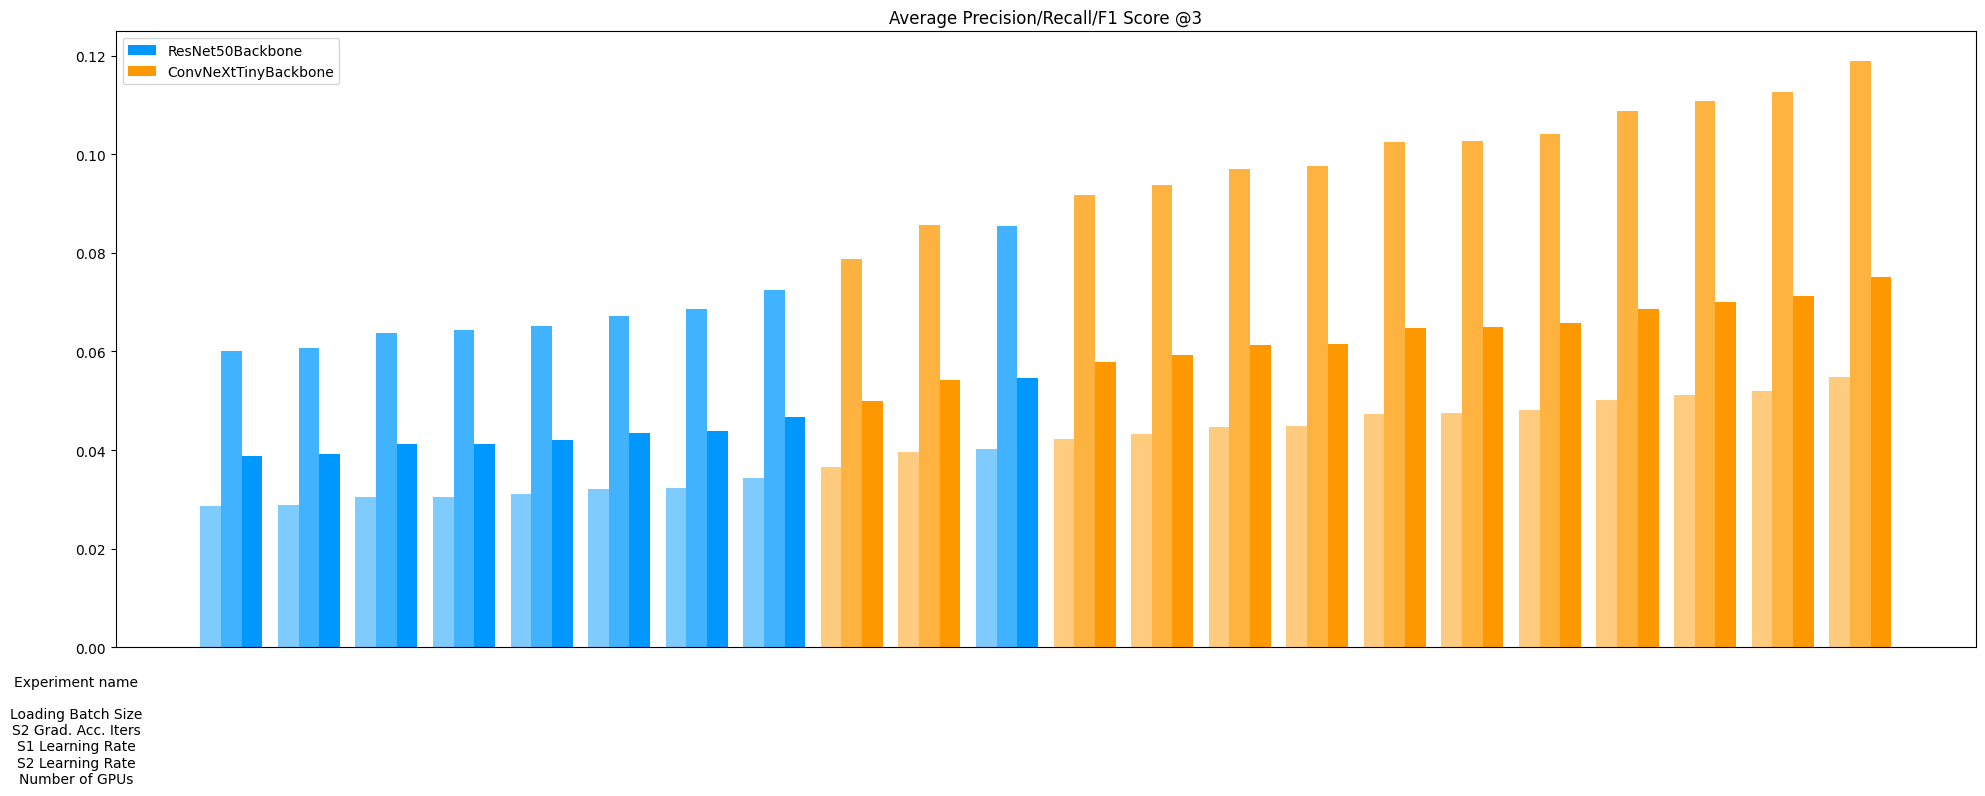

In [79]:
plt.figure(figsize=(24, 8))

###

bar_width = 0.8

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]
    
    if backbone == "ResNet50Backbone": backbone_color = np.asarray([0/256, 153/256, 255/256])
    if backbone == "EfficientNetB3Backbone": backbone_color = np.asarray([51/256, 153/256, 51/256])
    if backbone == "ConvNeXtTinyBackbone": backbone_color = np.asarray([255/256, 153/256, 0/256])

    plt.bar(np.asarray(ord_df_filt.index) - bar_width/3, ord_df_filt["avg_test_p_at_3"], width=bar_width/3, color=backbone_color, alpha=0.5)
    plt.bar(np.asarray(ord_df_filt.index), ord_df_filt["avg_test_r_at_3"], width=bar_width/3, color=backbone_color, alpha=0.75)
    plt.bar(np.asarray(ord_df_filt.index) + bar_width/3, ord_df_filt["avg_test_f1_at_3"], width=bar_width/3, label=backbone, color=backbone_color, alpha=1)

plt.legend()

###

plt.xticks([])
plt.title("Average Precision/Recall/F1 Score @3")

###

text_height = - plt.ylim()[1] * 0.22

text = "{:s}\n\n{:s}\n{:s}\n{:s}\n{:s}\n{:s}".format(
    "Experiment name",
    "Loading Batch Size",
    "S2 Grad. Acc. Iters",
    "S1 Learning Rate",
    "S2 Learning Rate",
    "Number of GPUs"
)
plt.text(-2, text_height, text, ha="center")

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]

    for idx in ord_df_filt.index:
        text = "{:s}\n\n{:d}\n{:d}\n{:.1e}\n{:.1e}\n{:d}".format(
            ord_df_filt.at[idx, "experiment_name"],
            ord_df_filt.at[idx, "loading_batch_size"],
            ord_df_filt.at[idx, "stage_2_grad_acc_iters"],
            ord_df_filt.at[idx, "stage_1_lr"],
            ord_df_filt.at[idx, "stage_2_lr"],
            ord_df_filt.at[idx, "num_gpus"]
        )
        plt.text(idx, text_height, text, ha="center", family="monospace")
        
###

plt.show()

In [ ]:
ord_df = df.sort_values("avg_test_f1_at_5", ascending=True)
ord_df = ord_df.reset_index(drop=True)

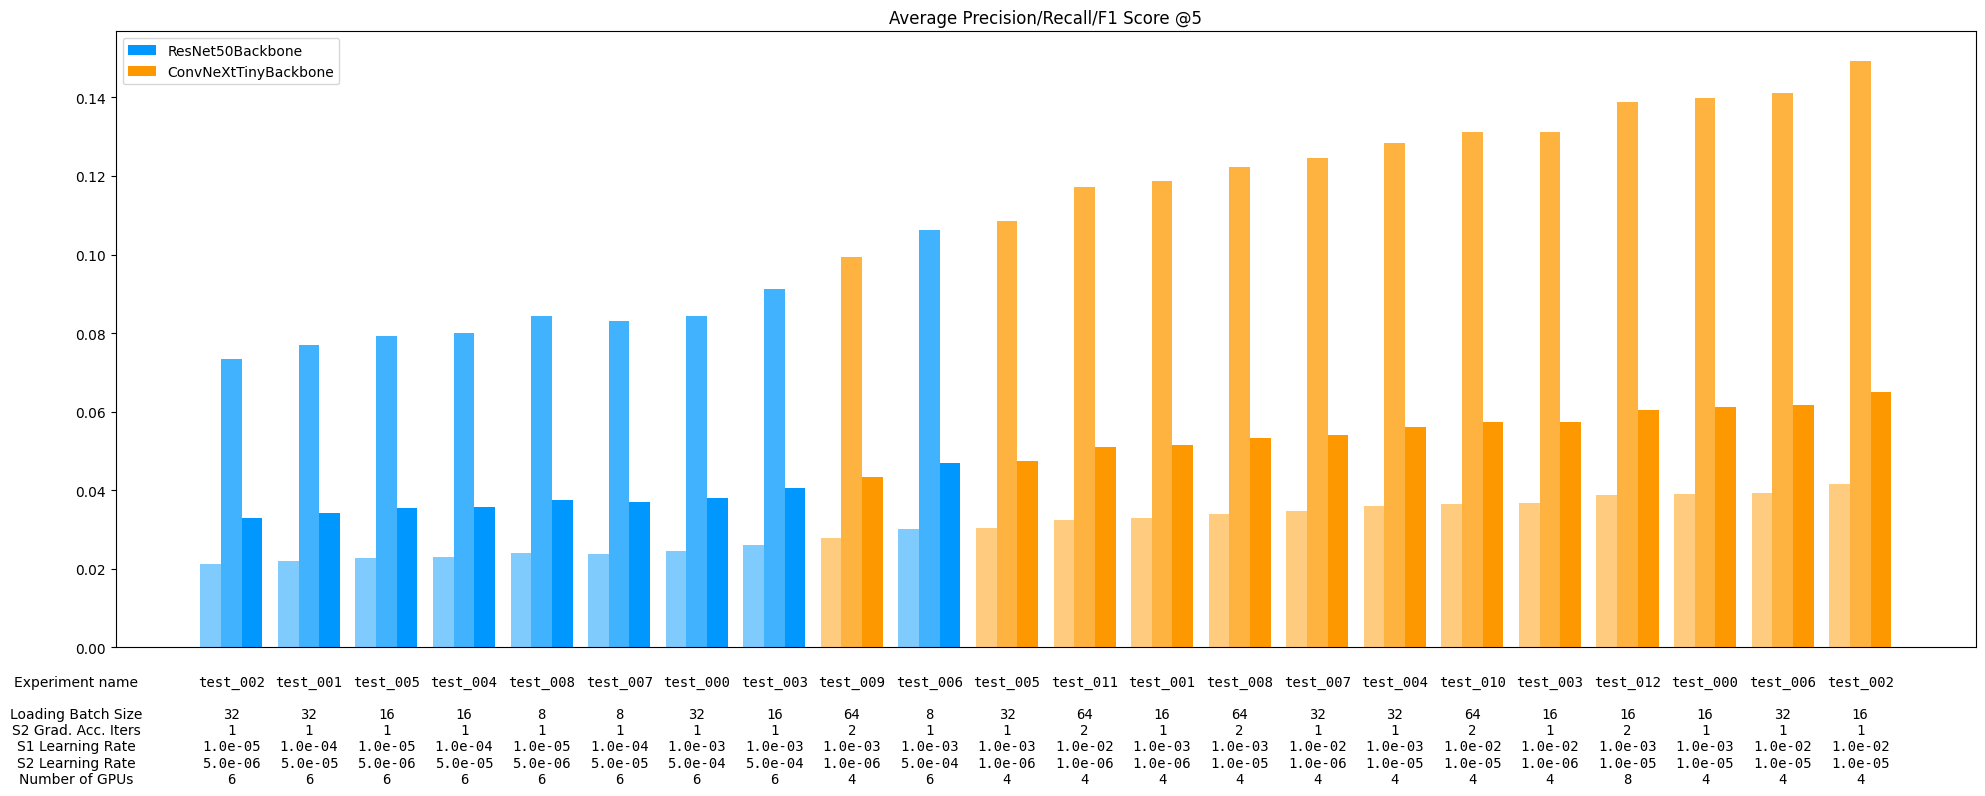

In [ ]:
plt.figure(figsize=(24, 8))

###

bar_width = 0.8

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]
    
    if backbone == "ResNet50Backbone": backbone_color = np.asarray([0/256, 153/256, 255/256])
    if backbone == "EfficientNetB3Backbone": backbone_color = np.asarray([51/256, 153/256, 51/256])
    if backbone == "ConvNeXtTinyBackbone": backbone_color = np.asarray([255/256, 153/256, 0/256])

    plt.bar(np.asarray(ord_df_filt.index) - bar_width/3, ord_df_filt["avg_test_p_at_5"], width=bar_width/3, color=backbone_color, alpha=0.5)
    plt.bar(np.asarray(ord_df_filt.index), ord_df_filt["avg_test_r_at_5"], width=bar_width/3, color=backbone_color, alpha=0.75)
    plt.bar(np.asarray(ord_df_filt.index) + bar_width/3, ord_df_filt["avg_test_f1_at_5"], width=bar_width/3, label=backbone, color=backbone_color, alpha=1)

plt.legend()

###

plt.xticks([])
plt.title("Average Precision/Recall/F1 Score @5")

###

text_height = - plt.ylim()[1] * 0.22

text = "{:s}\n\n{:s}\n{:s}\n{:s}\n{:s}\n{:s}".format(
    "Experiment name",
    "Loading Batch Size",
    "S2 Grad. Acc. Iters",
    "S1 Learning Rate",
    "S2 Learning Rate",
    "Number of GPUs"
)
plt.text(-2, text_height, text, ha="center")

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]

    for idx in ord_df_filt.index:
        text = "{:s}\n\n{:d}\n{:d}\n{:.1e}\n{:.1e}\n{:d}".format(
            ord_df_filt.at[idx, "experiment_name"],
            ord_df_filt.at[idx, "loading_batch_size"],
            ord_df_filt.at[idx, "stage_2_grad_acc_iters"],
            ord_df_filt.at[idx, "stage_1_lr"],
            ord_df_filt.at[idx, "stage_2_lr"],
            ord_df_filt.at[idx, "num_gpus"]
        )
        plt.text(idx, text_height, text, ha="center", family="monospace")
        
###

plt.show()

In [ ]:
ord_df = df.sort_values("avg_test_f1_at_10", ascending=True)
ord_df = ord_df.reset_index(drop=True)

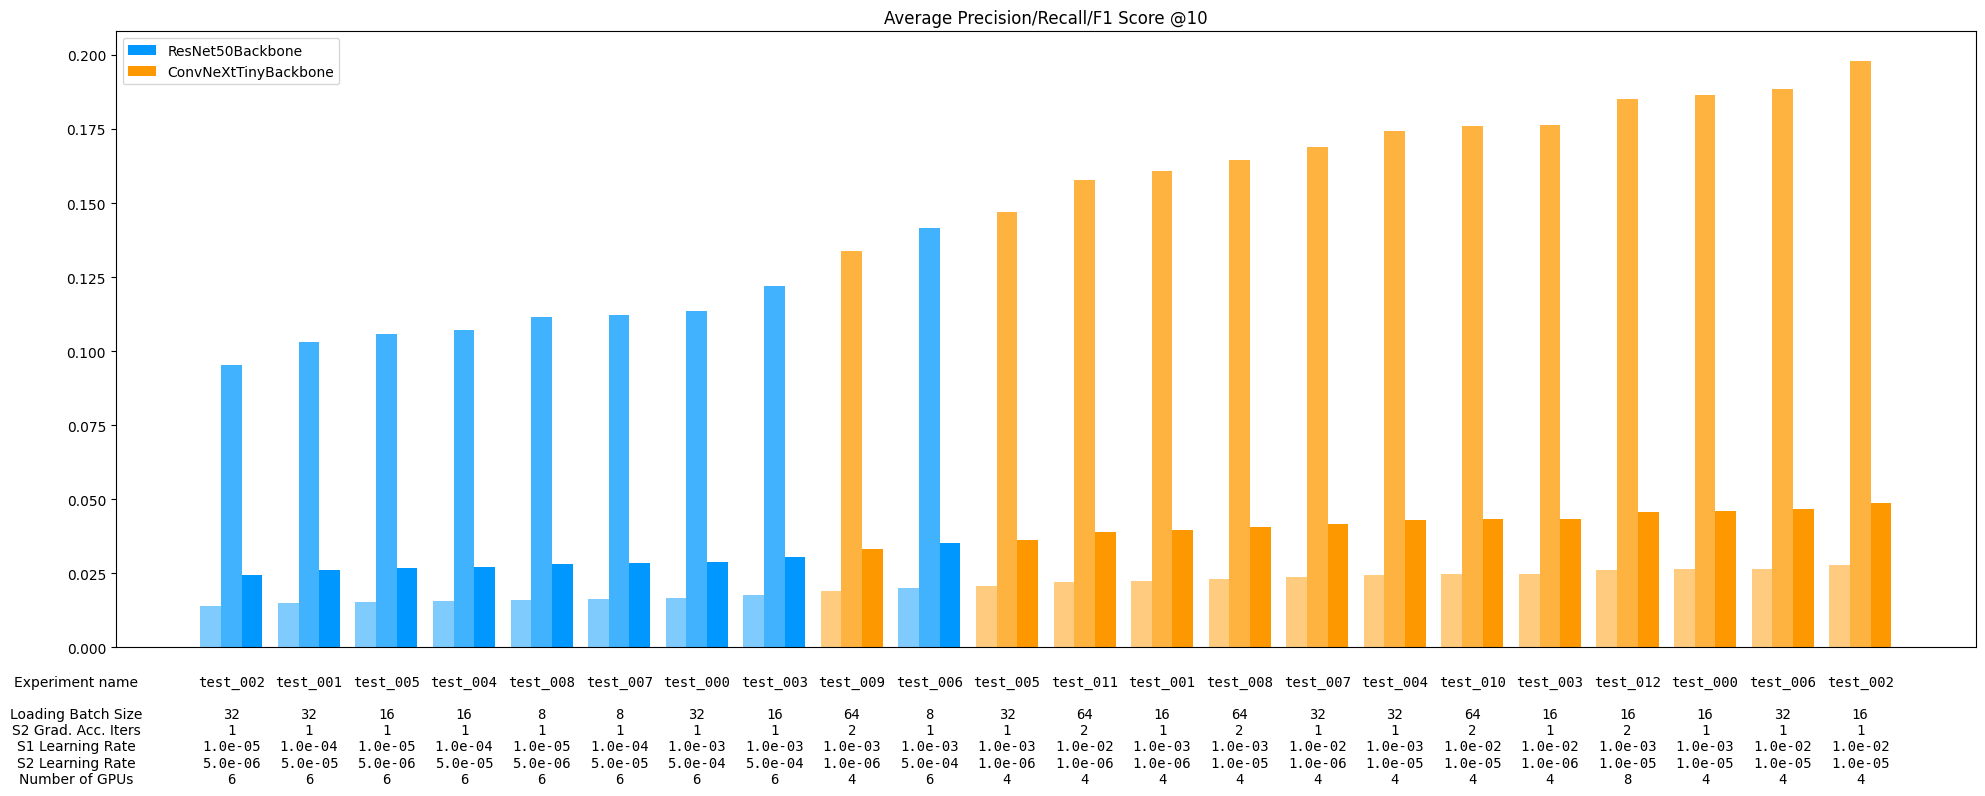

In [ ]:
plt.figure(figsize=(24, 8))

###

bar_width = 0.8

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]
    
    if backbone == "ResNet50Backbone": backbone_color = np.asarray([0/256, 153/256, 255/256])
    if backbone == "EfficientNetB3Backbone": backbone_color = np.asarray([51/256, 153/256, 51/256])
    if backbone == "ConvNeXtTinyBackbone": backbone_color = np.asarray([255/256, 153/256, 0/256])

    plt.bar(np.asarray(ord_df_filt.index) - bar_width/3, ord_df_filt["avg_test_p_at_10"], width=bar_width/3, color=backbone_color, alpha=0.5)
    plt.bar(np.asarray(ord_df_filt.index), ord_df_filt["avg_test_r_at_10"], width=bar_width/3, color=backbone_color, alpha=0.75)
    plt.bar(np.asarray(ord_df_filt.index) + bar_width/3, ord_df_filt["avg_test_f1_at_10"], width=bar_width/3, label=backbone, color=backbone_color, alpha=1)

plt.legend()

###

plt.xticks([])
plt.title("Average Precision/Recall/F1 Score @10")

###

text_height = - plt.ylim()[1] * 0.22

text = "{:s}\n\n{:s}\n{:s}\n{:s}\n{:s}\n{:s}".format(
    "Experiment name",
    "Loading Batch Size",
    "S2 Grad. Acc. Iters",
    "S1 Learning Rate",
    "S2 Learning Rate",
    "Number of GPUs"
)
plt.text(-2, text_height, text, ha="center")

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]

    for idx in ord_df_filt.index:
        text = "{:s}\n\n{:d}\n{:d}\n{:.1e}\n{:.1e}\n{:d}".format(
            ord_df_filt.at[idx, "experiment_name"],
            ord_df_filt.at[idx, "loading_batch_size"],
            ord_df_filt.at[idx, "stage_2_grad_acc_iters"],
            ord_df_filt.at[idx, "stage_1_lr"],
            ord_df_filt.at[idx, "stage_2_lr"],
            ord_df_filt.at[idx, "num_gpus"]
        )
        plt.text(idx, text_height, text, ha="center", family="monospace")
        
###

plt.show()

In [81]:
ord_df = df.sort_values("avg_test_r_at_10", ascending=True)
ord_df = ord_df.reset_index(drop=True)

In [85]:
ord_df["avg_test_r_at_10"].max()

0.19805790723895636

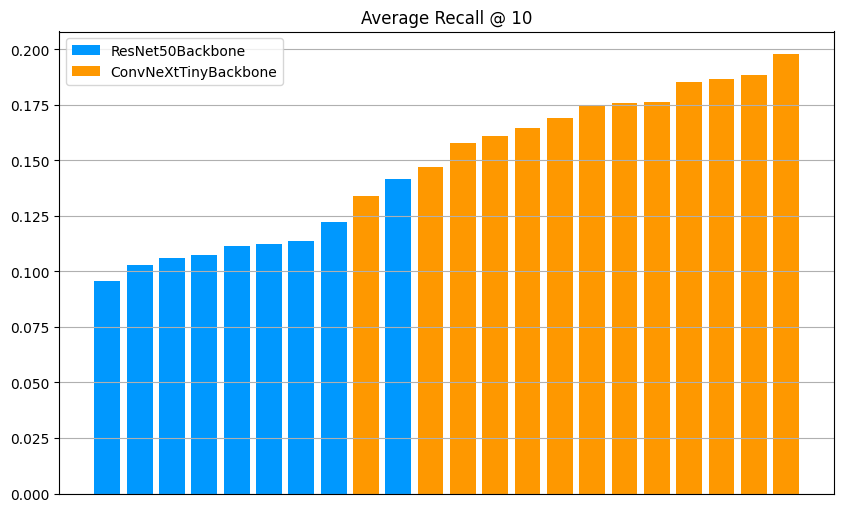

In [83]:
plt.figure(figsize=(10, 6))

###

bar_width = 0.8

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]
    
    if backbone == "ResNet50Backbone": backbone_color = np.asarray([0/256, 153/256, 255/256])
    if backbone == "EfficientNetB3Backbone": backbone_color = np.asarray([51/256, 153/256, 51/256])
    if backbone == "ConvNeXtTinyBackbone": backbone_color = np.asarray([255/256, 153/256, 0/256])

    plt.bar(np.asarray(ord_df_filt.index), ord_df_filt["avg_test_r_at_10"], color=backbone_color, alpha=1, label=backbone)

plt.legend()

###

plt.grid()
plt.xticks([])
plt.title("Average Recall @ 10")

###

"""
text_height = - plt.ylim()[1] * 0.22

text = "{:s}\n\n{:s}\n{:s}\n{:s}\n{:s}\n{:s}".format(
    "Experiment name",
    "S1 Batch Size",
    "S2 Batch Size",
    "S1 Learning Rate",
    "S2 Learning Rate",
    "Number of GPUs"
)
plt.text(-2, text_height, text, ha="center")

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]

    for idx in ord_df_filt.index:
        text = "{:s}\n\n{:3d}\n{:3d}\n{:3.2e}\n{:3.2e}\n{:1d}".format(
            ord_df_filt.at[idx, "experiment_name"],
            ord_df_filt.at[idx, "stage_1_actual_batch_size"],
            ord_df_filt.at[idx, "stage_2_actual_batch_size"],
            ord_df_filt.at[idx, "stage_1_base_lr"],
            ord_df_filt.at[idx, "stage_2_base_lr"],
            ord_df_filt.at[idx, "num_gpus"]
        )
        plt.text(idx, text_height, text, ha="center", family="monospace")
"""

###

plt.grid(True)
plt.show()